In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import torch
from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

### This package will be included in our repo, but it is only a prompt template

In [3]:
from golemai.nlp.prompts import QUERY_INTRO_NO_ANS, SYSTEM_MSG_RAG, SYSTEM_MSG_RAG_SHORT
from golemai.nlp.llm_module import prepare_prompt

In [ ]:
load_dotenv(), torch.cuda.is_available()

(True, True)

In [5]:
DATA_DIR = 'data'
DATASET_FILE = 'new_version_sample_1500.parquet'
QUESTION_COL = 'question'
CONTEXT_COL = 'context'
ANSWER_COL = 'answer'

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = os.path.join("..", DATA_DIR, DATASET_FILE)

In [7]:
df = pd.read_parquet(dataset_path)

In [8]:
df['dataset'].value_counts()

nq             438
poquad_v2      362
hotpotqa_en    253
polqa          171
hotpotqa_pl    155
bioask         121
Name: dataset, dtype: int64

In [9]:
df

,id,dataset,question,answer,context
4172,polqa_2503,polqa,Ile okrętów w 1588 r. liczyła Wielka Armada: 1...,130,`Dokument [1]:` 18 sierpnia królowa dokonała p...
1895,poquad_v2_4138,poquad_v2,"Po ilu dniach od premiery jego utwór ""Psycho"" ...",Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Post Malone"" ]:` 20 lutego 2018 r..."
5511,hotpotqa_en_5a85b16f5542991dd0999e8d,hotpotqa_en,Raja Rajendra is a 2015 Kannada comedy film th...,Ishita Dutta,"`Dokument [ ""Ouija (2015 film)"" ]:` Ouija (als..."
3427,hotpotqa_pl_5adfed45554299603e4183c5,hotpotqa_pl,Jakie jest wspólne zajęcie Sidney'ego Lumeta i...,scenarzystka,"`Dokument [ ""Gotham Independent Film Awards 19..."
2095,poquad_v2_48248,poquad_v2,W jakim programie telewizyjnym wystąpiła jako ...,Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Joanna Jędrzejczyk"" ]:` Od 2012 z..."
...,...,...,...,...,...
1924,poquad_v2_33786,poquad_v2,Jaka tradycja została zapoczątkowana w XVIII w...,Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Bridgwater"" ]:` W roku 1487 król ..."
962,nq_1431,nq,how many levels are there on the eiffel tower,three,"`Dokument [ ""Eiffel Tower"" ]:` a seasonal ice ..."
4191,hotpotqa_pl_5abd0d635542992ac4f381b8,hotpotqa_pl,Ile dni zajęło laureatowi nagrody dla Najlepsz...,29,"`Dokument [ ""List of Billboard 200 number-one ..."
3601,polqa_2593,polqa,"Jak nazywa się polski reżyser, mąż Jadwigi Bar...",Jerzy Antczak,"`Dokument [1]:` Albina Barańska, również jako ..."


In [10]:
df['context_length'] = df['context'].apply(lambda x: len(x.split()) if x else 0)

### Taking some samples for which the answer is wrong and check the attentions what went wrong

In [11]:
df.loc[df['context_length'] < 200].sort_values('context_length', ascending=True).head(10)

,id,dataset,question,answer,context,context_length
5914,bioask_966,bioask,Opisz zastosowanie oprogramowania Theatre do a...,Theatre to internetowy system obliczeniowy prz...,`Dokument [1]:` nan,3
6003,bioask_864,bioask,Które pakiety są używane do przeprowadzania an...,"IRanges, GenomicRanges i GenomicFeatures zapew...",`Dokument [1]:` nan,3
6050,bioask_4,bioask,Czy metformina zaburza wchłanianie tyroksyny?,"Nie. Nie zgłoszono danych wskazujących, że met...",`Dokument [1]:` nan,3
6143,bioask_608,bioask,Która fosfataza białkowa oddziałuje z białkiem...,Aktywność fosfatazy białkowej-1 jest regulowan...,`Dokument [1]:` nan,3
5199,polqa_6490,polqa,Które odznaczenie ustanowił król Stanisław Aug...,order Virtuti Militari,`Dokument [1]:` Za namową księcia Józefa Ponia...,18
3960,polqa_640,polqa,Czy w Brazylii uprawiana jest trzcina cukrowa?,tak,`Dokument [1]:` Gospodarka opierała się na poz...,30
5880,bioask_1197,bioask,Czy gen SDHAF2 koduje białko niezbędne do flaw...,"Tak, SDHAF2 lub hSDH5 to gen kodujący enzym od...",`Dokument [1]:` Przyzwojaki zostały powiązane ...,54
4892,hotpotqa_pl_5ab67ce2554299710c8d1ead,hotpotqa_pl,"Które z nich ma więcej gatunków w Azji, Dispor...",Disporum,"`Dokument [ ""Boltonia"" ]:` Boltonia to rodzaj ...",58
2539,poquad_v2_11059,poquad_v2,"Jaki status, poza jednym wyjątkiem, ma ten gry...",gatunku najmniejszej troski,"`Dokument [ ""Piaskogrzeb przylądkowy"" ]:` Pias...",65
3159,poquad_v2_3241,poquad_v2,Jakie religie nie akceptują odmiennego stosunk...,"islam, judaizm, katolicyzm","`Dokument [ ""Stosunek płciowy"" ]:` Stosunki an...",66


In [12]:
df = df.reset_index()

In [13]:
df

,index,id,dataset,question,answer,context,context_length
0,4172,polqa_2503,polqa,Ile okrętów w 1588 r. liczyła Wielka Armada: 1...,130,`Dokument [1]:` 18 sierpnia królowa dokonała p...,416
1,1895,poquad_v2_4138,poquad_v2,"Po ilu dniach od premiery jego utwór ""Psycho"" ...",Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Post Malone"" ]:` 20 lutego 2018 r...",115
2,5511,hotpotqa_en_5a85b16f5542991dd0999e8d,hotpotqa_en,Raja Rajendra is a 2015 Kannada comedy film th...,Ishita Dutta,"`Dokument [ ""Ouija (2015 film)"" ]:` Ouija (als...",773
3,3427,hotpotqa_pl_5adfed45554299603e4183c5,hotpotqa_pl,Jakie jest wspólne zajęcie Sidney'ego Lumeta i...,scenarzystka,"`Dokument [ ""Gotham Independent Film Awards 19...",206
4,2095,poquad_v2_48248,poquad_v2,W jakim programie telewizyjnym wystąpiła jako ...,Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Joanna Jędrzejczyk"" ]:` Od 2012 z...",88
...,...,...,...,...,...,...,...
1495,1924,poquad_v2_33786,poquad_v2,Jaka tradycja została zapoczątkowana w XVIII w...,Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Bridgwater"" ]:` W roku 1487 król ...",232
1496,962,nq_1431,nq,how many levels are there on the eiffel tower,three,"`Dokument [ ""Eiffel Tower"" ]:` a seasonal ice ...",1048
1497,4191,hotpotqa_pl_5abd0d635542992ac4f381b8,hotpotqa_pl,Ile dni zajęło laureatowi nagrody dla Najlepsz...,29,"`Dokument [ ""List of Billboard 200 number-one ...",791
1498,3601,polqa_2593,polqa,"Jak nazywa się polski reżyser, mąż Jadwigi Bar...",Jerzy Antczak,"`Dokument [1]:` Albina Barańska, również jako ...",288


In [14]:
IDX = 5199

### Very interesting example, because it is required to properly filter noise and extract info from the end

In [15]:
df.loc[df['index'] == IDX]

,index,id,dataset,question,answer,context,context_length
443,5199,polqa_6490,polqa,Które odznaczenie ustanowił król Stanisław Aug...,order Virtuti Militari,`Dokument [1]:` Za namową księcia Józefa Ponia...,18


In [16]:
df.iloc[IDX][CONTEXT_COL]

IndexError: single positional indexer is out-of-bounds

In [15]:
query, context = df.iloc[IDX][QUESTION_COL], df.iloc[IDX][CONTEXT_COL]

In [16]:
sample_prompt = QUERY_INTRO_NO_ANS.format(context=context, query=query)
sample_prompt

'Given the context `CONTEXT` and the query `QUERY` below, please provide an answer `ANSWER` to the question. \n    `CONTEXT`: `Dokument [1]:` Wacław Stanisław Sitkowski (ur. 12 lutego 1924 w Warszawie, zm. 1 kwietnia 2010 tamże) – polski lekarz, kardiochirurg, profesor nauk medycznych, powstaniec warszawski. Jeden z pionierów polskiej kardiochirurgii, nauczyciel polskich kardiochirurgów, w tym Zbigniewa Religi. \n\n    `QUERY`: Jak miał na imię polski kardiochirurg, profesor Religa?\n\n    `ANSWER`:\n'

### I will load our standard `unsloth/gemma-2-9b-it-bnb-4bit`

In [17]:
MODEL_ID = "unsloth/gemma-2-9b-it-bnb-4bit"
DTYPE = torch.bfloat16
LOAD_IN_4BIT = True

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=os.environ["HF_TOKEN"])
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map='auto',
    torch_dtype=DTYPE,
    token=os.environ["HF_TOKEN"],
    # sliding_window=8192
    # max_memory={0: "4GB", 1: "3GB"}
    #attn_implementation="sdpa",
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [19]:
att_path = '/home/pim/Research/scripts/gemma2_new_dataset/attentions/poquad_v2_23335.npy'

In [116]:
def weighted_avg_window_att(
    x: np.ndarray,
    window_size: int,
) -> float:
    
    weights = -np.tanh(np.arange(1, window_size + 1) - window_size - 1)
    weights /= weights.sum()

    print(f"weights: {weights}")
    print(f'{x.shape=}')

    return np.average(x, weights=weights, axis=-1)

In [113]:
def agg_att_weighted(x: np.ndarray, window_size: int = 8, passage_percentage: float = 0.2) -> np.ndarray:

    return np.concatenate((
            weighted_avg_window_att(
                x=x.sum(axis=-1),
                window_size=window_size,
            ).flatten(), 
            np.array([passage_percentage])
        ))

In [119]:
def get_windowed_att_tensor(
    att_tensor: np.ndarray,
    window_size: int,
    window_step: int,
    postprocess_fn: callable,
    use_passage_percentage: bool = False,
    passage_length: int = 0,
    n_prompt_tokens: int = 0,
    passage_perc_round: int = 3,
    **kwargs,
) -> dict:
    
    att_tensor_dict = {}

    for i in range(0, att_tensor.shape[-2], window_step):

        if i + window_size <= att_tensor.shape[-2]:
            
            if use_passage_percentage:
                all_tokens = n_prompt_tokens + (2 * i + window_size) // 2
                kwargs['passage_percentage'] = round(passage_length / all_tokens, passage_perc_round)
                kwargs['window_size'] = window_size

            att_tensor_dict[tuple([i, i + window_size])] = postprocess_fn(att_tensor[..., i: i + window_size, :], **kwargs)

    del att_tensor
    return att_tensor_dict

In [88]:
from copy import deepcopy

In [110]:
def prep_att_pipe(
    att_path: str,
    n_first_tokens: int = None,
    skip_first_n_tokens: int = None,
    skip_last_n_tokens: int = None,
    n_passage_tokens_start_idx: int = None,
    n_passage_tokens_end_idx: int = None,
    window_size: int = 0,
    window_step: int = 4,
    postprocess_fn: callable = None,
    valid_example_th: int = 4,
    use_passage_percentage: bool = False,
    **kwargs: dict,
) -> np.ndarray:
    """
    Function to prepare the attention tensor for further analysis.
    It removes the prompt tokens and the last offset_size tokens from the context.
    """

    att_tensor = np.load(att_path)

    skip_first_n_tokens = skip_first_n_tokens if skip_first_n_tokens is not None else 0
    skip_last_n_tokens = skip_last_n_tokens if skip_last_n_tokens is not None else 0
    n_first_tokens = n_first_tokens if n_first_tokens is not None else att_tensor.shape[-2]

    passage_length = n_passage_tokens_end_idx - n_passage_tokens_start_idx

    if kwargs.get('n_prompt_tokens') is None:
        kwargs['n_prompt_tokens'] = att_tensor.shape[-1] - att_tensor.shape[-2] 

    n_context_tokens = deepcopy(att_tensor.shape[-1])

    att_tensor = att_tensor[..., slice(skip_first_n_tokens, n_first_tokens + skip_first_n_tokens - skip_last_n_tokens), slice(n_passage_tokens_start_idx, n_passage_tokens_end_idx)]
    
    if att_tensor.shape[-2] < valid_example_th:
        return None
    
    print(f"{att_tensor.shape = }")

    if (window_size) and (att_tensor.shape[-2] > window_size):

        print(f"Using windowed attention with window size: {window_size} and step: {window_step}")

        att_tensor = get_windowed_att_tensor(
            att_tensor=att_tensor,
            window_size=window_size,
            window_step=window_step,
            postprocess_fn=postprocess_fn,
            passage_length=passage_length,
            use_passage_percentage=use_passage_percentage,
            **kwargs,
        )

    else:

        if use_passage_percentage:
            kwargs['passage_percentage'] = round(passage_length / (n_context_tokens), 3)
            kwargs['window_size'] = att_tensor.shape[-2]

        att_tensor = postprocess_fn(att_tensor, **kwargs)

    return att_tensor

In [99]:
SKIP_FIRST = 8
SKIP_LAST = 2
START_IDX = 100
END_IDX = 200
WINDOW_STEP = 1
WINDOW_SIZE = 8

In [118]:
prep_att_pipe(
    att_path=att_path,
    n_first_tokens=None,
    skip_first_n_tokens=SKIP_FIRST,
    skip_last_n_tokens=SKIP_LAST,
    n_passage_tokens_start_idx=START_IDX,
    n_passage_tokens_end_idx=END_IDX,
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP,
    postprocess_fn=agg_att_weighted,
    valid_example_th=4,
    use_passage_percentage=True,
)[(0, 8)][-1]

att_tensor.shape = (42, 16, 14, 100)
Using windowed attention with window size: 8 and step: 1
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)
weights: [0.12953531 0.12953513 0.12953375 0.12952358 0.12944846 0.12889476
 0.12487564 0.09865336]
x.shape=(42, 16, 8)


0.288

In [12]:
df['formatted_context'] = df.apply(
    lambda row: SYSTEM_MSG_RAG + QUERY_INTRO_NO_ANS.format(context=row['context'], query=row['question']),
    axis=1
)

In [13]:
df['context_length'] = df['formatted_context'].apply(lambda x: len(tokenizer(x, return_tensors='pt')['input_ids'][0]) if x else 0)

In [14]:
df['answer_length'] = df['answer'].apply(lambda x: len(tokenizer(x, return_tensors='pt')['input_ids'][0]) if x else 0)

In [15]:
df['answer_length'].describe()

count    1500.000000
mean       16.127333
std       109.789144
min         2.000000
25%         3.000000
50%         5.000000
75%        10.000000
max      4097.000000
Name: answer_length, dtype: float64

In [16]:
(df['context_length'] < 3900).sum() / len(df)

0.984

In [20]:
df.loc[df['context_length'] > 3900].shape

(24, 8)

In [22]:
(df['answer_length'] < 200).sum() / len(df)

0.9913333333333333

In [23]:
df = df[df['context_length'] < 3900]

In [24]:
len(df)

1476

In [26]:
df['dataset'].value_counts()

dataset
nq             438
poquad_v2      362
hotpotqa_en    253
polqa          171
hotpotqa_pl    154
bioask          98
Name: count, dtype: int64

In [28]:
df.to_parquet(dataset_path.replace('.parquet', '_filtered.parquet'))

In [19]:
df['context_length'].quantile(0.99)

7017.0999999999985

In [21]:
df['answer_length'] = df['answer'].apply(lambda x: len(tokenizer(x, return_tensors='pt')['input_ids'][0]) if x else 0)  

In [35]:
df = df.loc[df['dataset'] != 'REASON']
df = df.drop(columns=['formatted_context'])

In [ ]:
# df.to_parquet(os.path.join("..", DATA_DIR, 'test_gemma_resp_dola.parquet'), index=False)

In [39]:
(df['context_length'] < 3500).sum()

3814

In [23]:
(df['answer_length'] < 100).sum()

3843

In [27]:
reversed_tokenizer = {v: k for k, v in tokenizer.get_vocab().items()}


### Last `n x n` dims are the attention matrix - for new generated token it will have shape: `length of input sequence + 1 x length of input sequence`

In [10]:
inputs = tokenizer('eeee' * 24, return_tensors="pt", padding=True).to(device)
inputs

{'input_ids': tensor([[     2, 165836, 165836, 165836, 165836, 165836, 165836, 165836, 165836,
         165836, 165836, 165836, 165836]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [11]:
inputs['input_ids'].shape

torch.Size([1, 13])

### Here is tokenized input

In [12]:
for i, tok in enumerate(inputs["input_ids"][0], start=1):
    print(f'{i}. {reversed_tokenizer[tok.item()]}')

NameError: name 'reversed_tokenizer' is not defined

### To get attensions and hidden states it is required to set 
```python
return_dict_in_generate=True`
```

In [14]:
from numba import jit, njit
import numpy as np

In [15]:
@njit(parallel=True)
def process_hidden_or_att(
        x,
    ) -> np.ndarray:
        """
        Processes hidden states or attention weights from a tuple of tensors.
        Args:
            x (Tuple[Tuple[torch.Tensor]]): A tuple of tuples containing torch tensors.
                Each inner tuple represents the hidden states or attention weights for a token.
        Returns:
            np.ndarray: A numpy array containing the processed hidden states or attention weights.
                The array is concatenated along the last dimension, with an additional dimension
                added for all but the first element in the input tuple.
        """

        n_generated_tokens = len(x) - 1
        n_layers = 42
        n_heads = 16
        n_prompt_tokens = x[0][0].shape[-2]

        # print(f"n_prompt_tokens: {n_prompt_tokens}, n_generated_tokens: {n_generated_tokens}")

        num_all_tokens = n_prompt_tokens + n_generated_tokens
        prompt_offset = 0
        take_only_generated = True

        init_matrix = np.zeros(shape=(
            n_layers, 
            n_heads,
            num_all_tokens, 
            num_all_tokens), 
        dtype=np.float32)

        for i, t in enumerate(x[0]):
            init_matrix[i, :, :n_prompt_tokens, :] = t[..., :num_all_tokens]

        for i, token_att in enumerate(x[1:]):
            for j, t in enumerate(token_att):
                init_matrix[j, :, n_prompt_tokens + i, :] = t[..., :num_all_tokens]

        return init_matrix[:, :, (max(n_prompt_tokens - prompt_offset, 0)) if take_only_generated else 0:, :]

In [16]:
inputs = tokenizer('what is the capitol of france? write me poem about it', return_tensors="pt", padding=True).to(device)

generated_ans = model.generate(
    **inputs,
    output_attentions=True,
    output_hidden_states=False,
    return_dict_in_generate=True,
    max_new_tokens=200,
    use_cache=True,
    # cache_implementation=None
)

In [ ]:
s = process_hidden_or_att(tuple(
    tuple(
        [l.detach().cpu().to(torch.float32).numpy().squeeze() for l in token]
    )
    for token in generated_ans.attentions
))

In [45]:
s.shape

(42, 16, 176, 190)

In [49]:
s1 = process_hidden_or_att(generated_ans.attentions)

n_prompt_tokens: 14, n_generated_tokens: 176


In [50]:
s1.shape

(42, 16, 176, 190)

In [52]:
(s == s1).all()

True

In [87]:
%timeit process_hidden_or_att(generated_ans.attentions)

n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
n_prompt_tokens: 14, n_generated_tokens: 176
The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
1.69 s ± 566 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
from golemai.nlp.prompts import QUERY_INTRO_NO_ANS, SYSTEM_MSG_RAG, SYSTEM_MSG_RAG_SHORT
from golemai.nlp.llm_module import prepare_prompt
from golemai.nlp.llm_resp_gen import LLMRespGen

In [18]:
df1 = pd.read_parquet(os.path.join("..", DATA_DIR, 'new_version_merged_df.parquet'))

In [19]:
llm_rg = LLMRespGen(
    df=df1,
    model_type='local',
    system_msg=SYSTEM_MSG_RAG_SHORT,
    prompt_template=QUERY_INTRO_NO_ANS,
    batch_size=1,
)

Using device: cuda, device_num = 0


In [20]:
df1 = df1.rename(columns={'question': 'query'}) 

In [21]:
llm_rg.llm = model
llm_rg.tokenizer = tokenizer

In [23]:
context_lengths = []

for i, row in df1.iterrows():

    formatted_prompt = llm_rg._get_ready_prompt(
        row=row,
        prompt_columns=['query', 'context']
    )

    inputs = tokenizer(formatted_prompt + row['answer'], return_tensors="pt", padding=True, add_special_tokens=False)
    context_lengths.append(inputs['input_ids'].shape[-1])

In [24]:
context_lengths = np.array(context_lengths)

In [28]:
df1['context_length'] = context_lengths

In [29]:
df1.to_parquet(os.path.join("..", DATA_DIR, 'new_version_merged_df.parquet'))

In [30]:
df2 = pd.read_parquet(os.path.join("..", DATA_DIR, 'new_version_sample_1500_filtered.parquet'))

In [35]:
df2.reset_index().iloc[:679]['id'].values

array(['polqa_2503', 'poquad_v2_4138',
       'hotpotqa_en_5a85b16f5542991dd0999e8d',
       'hotpotqa_pl_5adfed45554299603e4183c5', 'poquad_v2_48248',
       'hotpotqa_en_5ab2f338554299166977414d', 'poquad_v2_53158',
       'poquad_v2_16175', 'bioask_991',
       'hotpotqa_en_5ac4f2f055429924173fb505', 'poquad_v2_44979',
       'nq_2566', 'polqa_6317', 'hotpotqa_en_5ac2bcaa55429921a00ab04b',
       'nq_1933', 'polqa_2574', 'hotpotqa_pl_5abbf3845542993f40c73c2e',
       'hotpotqa_en_5a7da50b5542995ed0d16650', 'polqa_719',
       'hotpotqa_pl_5ae5a4e5554299546bf82f01', 'nq_754',
       'hotpotqa_en_5a855afc5542991dd0999e54',
       'hotpotqa_en_5a7f3d325542992e7d278cb5',
       'hotpotqa_en_5ae2a177554299495565daf0',
       'hotpotqa_en_5ae5a43e554299546bf82efe',
       'hotpotqa_en_5a8b3dd75542997f31a41cc2', 'nq_2505', 'nq_1665',
       'hotpotqa_en_5a7bad48554299294a54aa8f',
       'hotpotqa_en_5ade956b554299728e26c743', 'poquad_v2_34539',
       'nq_2628', 'hotpotqa_pl_5ab310bb554299

In [36]:
df1 = df1.loc[~df1['id'].isin(df2.reset_index().iloc[:680]['id'].values)]

In [39]:
df1.reset_index(drop=True).to_parquet(os.path.join("..", DATA_DIR, 'new_version_rest_sample.parquet'))

In [27]:
(context_lengths > 4096).sum() / len(context_lengths)

0.010764781491002571

In [111]:
pip install jinja2>=3.1.0

Note: you may need to restart the kernel to use updated packages.


In [99]:
df1.reset_index().iloc[:679]

,index,id,dataset,question,answer,context,formatted_context,context_length,answer_length
0,4172,polqa_2503,polqa,Ile okrętów w 1588 r. liczyła Wielka Armada: 1...,130,`Dokument [1]:` 18 sierpnia królowa dokonała p...,\n You are a helpful assistant. Your job wi...,1366,4
1,1895,poquad_v2_4138,poquad_v2,"Po ilu dniach od premiery jego utwór ""Psycho"" ...",Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Post Malone"" ]:` 20 lutego 2018 r...",\n You are a helpful assistant. Your job wi...,607,17
2,5511,hotpotqa_en_5a85b16f5542991dd0999e8d,hotpotqa_en,Raja Rajendra is a 2015 Kannada comedy film th...,Ishita Dutta,"`Dokument [ ""Ouija (2015 film)"" ]:` Ouija (als...",\n You are a helpful assistant. Your job wi...,1658,4
3,3427,hotpotqa_pl_5adfed45554299603e4183c5,hotpotqa_pl,Jakie jest wspólne zajęcie Sidney'ego Lumeta i...,scenarzystka,"`Dokument [ ""Gotham Independent Film Awards 19...",\n You are a helpful assistant. Your job wi...,839,5
4,2095,poquad_v2_48248,poquad_v2,W jakim programie telewizyjnym wystąpiła jako ...,Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Joanna Jędrzejczyk"" ]:` Od 2012 z...",\n You are a helpful assistant. Your job wi...,585,17
...,...,...,...,...,...,...,...,...,...
674,5089,polqa_2264,polqa,W jakich górach w Polsce znajdują się złoża ma...,w Sudetach,`Dokument [1]:` W Polsce: spotykany bywa w Gór...,\n You are a helpful assistant. Your job wi...,1647,4
675,5912,bioask_1734,bioask,Jaki był cel badania klinicznego HAMLET?,Celem badania klinicznego HAMLET (Hemicraniect...,`Dokument [1]:` TŁO: Pacjenci z zawałami półku...,\n You are a helpful assistant. Your job wi...,3506,79
676,1927,poquad_v2_39470,poquad_v2,"Czy zaleca się leczenie osób, które nie są w g...",Nie mogę udzielić odpowiedzi na to pytanie na ...,"`Dokument [ ""Schizofrenia"" ]:` Nie istnieją ża...",\n You are a helpful assistant. Your job wi...,684,17
677,3412,hotpotqa_en_5ae01d70554299603e4183ea,hotpotqa_en,Martin Beck grew up 20 blocks from a neighborh...,Niagara Falls,"`Dokument [ ""Hunters Green"" ]:` Hunters Green ...",\n You are a helpful assistant. Your job wi...,1693,3


In [62]:
v, h = process_hidden_or_att(generated_ans.attentions, take_only_generated=True, offset=8)

n_prompt_tokens: 7, n_generated_tokens: 13


In [60]:
last_b = b.copy()

In [58]:
a.shape, b.shape

((42, 16, 7, 20), (42, 16, 13, 20))

In [42]:
np.stack([a, b], axis=-2).shape

ValueError: all input arrays must have the same shape

In [28]:
len(generated_ans.attentions)

8

In [29]:
len(generated_ans.attentions[0])

42

In [31]:
tokenizer.batch_decode(generated_ans.sequences, skip_special_tokens=True)

['Given the context `CONTEXT` and the query `QUERY` below, please provide an answer `ANSWER` to the question. \n    `CONTEXT`: `Dokument [1]:` Wacław Stanisław Sitkowski (ur. 12 lutego 1924 w Warszawie, zm. 1 kwietnia 2010 tamże) – polski lekarz, kardiochirurg, profesor nauk medycznych, powstaniec warszawski. Jeden z pionierów polskiej kardiochirurgii, nauczyciel polskich kardiochirurgów, w tym Zbigniewa Religi. \n\n    `QUERY`: Jak miał na imię polski kardiochirurg, profesor Religa?\n\n    `ANSWER`:\n    Wacław \n\n\n']

In [32]:
print(tokenizer.decode(generated_ans.sequences[0]).strip())

<bos>Given the context `CONTEXT` and the query `QUERY` below, please provide an answer `ANSWER` to the question. 
    `CONTEXT`: `Dokument [1]:` Wacław Stanisław Sitkowski (ur. 12 lutego 1924 w Warszawie, zm. 1 kwietnia 2010 tamże) – polski lekarz, kardiochirurg, profesor nauk medycznych, powstaniec warszawski. Jeden z pionierów polskiej kardiochirurgii, nauczyciel polskich kardiochirurgów, w tym Zbigniewa Religi. 

    `QUERY`: Jak miał na imię polski kardiochirurg, profesor Religa?

    `ANSWER`:
    Wacław 


<end_of_turn><eos>


In [33]:
for i, tok in enumerate(generated_ans.sequences[0], start=1):
    print(f'{i}. {reversed_tokenizer[tok.item()]}')

1. <bos>
2. Given
3. ▁the
4. ▁context
5. ▁`
6. CONTEXT
7. `
8. ▁and
9. ▁the
10. ▁query
11. ▁`
12. QUERY
13. `
14. ▁below
15. ,
16. ▁please
17. ▁provide
18. ▁an
19. ▁answer
20. ▁`
21. ANSWER
22. `
23. ▁to
24. ▁the
25. ▁question
26. .
27. ▁
28. 

29. ▁▁▁▁
30. `
31. CONTEXT
32. `:
33. ▁`
34. Dokument
35. ▁[
36. 1
37. ]:
38. `
39. ▁W
40. ac
41. ław
42. ▁Stanisław
43. ▁Sit
44. kowski
45. ▁(
46. ur
47. .
48. ▁
49. 1
50. 2
51. ▁lutego
52. ▁
53. 1
54. 9
55. 2
56. 4
57. ▁w
58. ▁Warszawie
59. ,
60. ▁zm
61. .
62. ▁
63. 1
64. ▁kwietnia
65. ▁
66. 2
67. 0
68. 1
69. 0
70. ▁tam
71. że
72. )
73. ▁–
74. ▁polski
75. ▁le
76. karz
77. ,
78. ▁kard
79. io
80. chir
81. urg
82. ,
83. ▁profesor
84. ▁nau
85. k
86. ▁medy
87. cznych
88. ,
89. ▁powst
90. ani
91. ec
92. ▁warszaw
93. ski
94. .
95. ▁Jeden
96. ▁z
97. ▁pion
98. ier
99. ów
100. ▁polskiej
101. ▁kard
102. io
103. chir
104. ur
105. gii
106. ,
107. ▁nauczy
108. ciel
109. ▁polskich
110. ▁kard
111. io
112. chir
113. urg
114. ów
115. ,
116. ▁w
117. ▁tym
118. ▁Z

In [34]:
display(Markdown(f"### Number of layers: {model.config.num_hidden_layers}"))
display(Markdown(f"### Number of heads: {model.config.num_attention_heads}"))

### Number of layers: 42

### Number of heads: 16

### Important to offload tensors to `cpu` when doing research - so much faster

In [35]:
generated_ans.sequences.to('cpu')

tensor([[     2,  24985,    573,   4807,   4103,  71157, 235376,    578,    573,
           8164,   4103,  63741, 235376,   3582, 235269,   3743,   3658,    671,
           3448,   4103,  72601, 235376,    577,    573,   2872, 235265, 235248,
            108,    141, 235376,  71157,  74412,   4103, 132651,    892, 235274,
           8254, 235376,    647,    550,  32276, 171661,  30345,  74703,    591,
            525, 235265, 235248, 235274, 235284, 124194, 235248, 235274, 235315,
         235284, 235310,    513, 155044, 235269,  26385, 235265, 235248, 235274,
         129957, 235248, 235284, 235276, 235274, 235276,  10885,   8013, 235275,
           1157, 126020,    709, 106651, 235269,  85815,    536,  57325,   3457,
         235269,  55938,  18975, 235273, 109887,  78130, 235269, 147047,   3746,
            546, 232747,  13750, 235265, 164582,    868,  75362,   1129,   4712,
         204357,  85815,    536,  57325,    525,  87226, 235269, 137135,  88323,
         181725,  85815,    

### How many tokens for each example were produced

In [36]:
df['tokens'] = df['gemma-2-9b-it-bnb-4bit'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [37]:
df['tokens'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

0.250      4.000
0.500      7.000
0.750     18.000
0.900     31.000
0.950     47.000
0.990    126.910
0.999    883.024
Name: tokens, dtype: float64

In [38]:
df['tokens'].nlargest(25)

3909    1025
1974    1022
3571    1009
1640     986
3415     890
3979     826
3973     808
1976     640
763      444
3887     312
3780     288
1909     278
2644     269
1484     267
64       265
314      262
2407     262
27       260
1298     259
30       236
543      235
1843     206
3072     190
315      182
1074     179
Name: tokens, dtype: int64

In [39]:
len(generated_ans.sequences[0])

158

### I compared versions using ```python use_cache=True``` with version without it and for cached version for each generated token vector is produced (only for first one it is a matrix) - but here there are also positions which are used for future cache - so for 50 tokens it is not **n^2 - 50 x 50** but **50 x `max_tokens`**. And not generated tokens but all of them (`context length`) of example. So if there is 150 tokens in prompt and 11 tokens are generated, but you set `python max_new_tokens = 200` you will get for first token:
```python
attensions[0][0].squeeze(0)[0].shape
torch.Size([150, 350])
```
### And for next tokens
```python
attensions[1][0].squeeze(0)[0].shape
torch.Size([1, 350])
```

In [40]:
attensions = generated_ans.attentions
attensions = [tuple(att.cpu().squeeze(-1) for att in tok) for tok in attensions]

In [41]:
attensions[0][0].squeeze(0)[0].shape

torch.Size([150, 350])

In [43]:
attensions[0][0].shape, attensions[0][1].shape, attensions[0][2].shape

(torch.Size([1, 16, 150, 350]),
 torch.Size([1, 16, 150, 350]),
 torch.Size([1, 16, 150, 350]))

In [29]:
attensions[1][0].squeeze(0)[0].shape

torch.Size([1, 350])

### So as you can see `torch` prepare vec for cache (these 200 additional values), but attention is in `prompt_length` + `num_generated_tokens`:



In [56]:
input_len = len(inputs['input_ids'][0])
input_len

150

In [58]:
output_len = len(generated_ans.sequences[0])
output_len

161

In [59]:
attensions[-1][0].squeeze(0)[0].shape

torch.Size([1, 350])

### Values for the remaining positions are `zeros`:

In [67]:
attensions[-1][0].squeeze(0)[0].squeeze(0)[output_len - 1:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float16)

In [ ]:
first_token_attentions = torch.stack([att for att in attensions[0]]).squeeze(1)
last_token_attentions = torch.stack([att for att in attensions[-1]]).squeeze(1)

### Here is how it looked like for the version without cache (*26 layers and 8 heads for gemma 2 2b*)
```python

first_token_attentions.shape, last_token_attentions.shape
(torch.Size([26, 8, 150, 150]), torch.Size([26, 8, 169, 169]))
```

### I will show single matrix with max reduction on layers and heads

In [ ]:
final_att_matrix = np.zeros(shape=(len(attensions), last_token_attentions.shape[-1]))

for i, token_attensions in enumerate(attensions):

    token_last_att = torch.stack([att for att in token_attensions]).squeeze(1)
    token_last_att = token_last_att.numpy().max(axis=(0, 1))

    final_att_matrix[i, :len(token_last_att)] = token_last_att[-1, :]

In [177]:
final_att_matrix.shape

(20, 169)

In [184]:
ticks = [reversed_tokenizer[tok.item()] for tok in generated_ans.sequences[0]][:-1]

In [208]:
input_len = len(inputs["input_ids"][0])
first_gen_token_idx = input_len

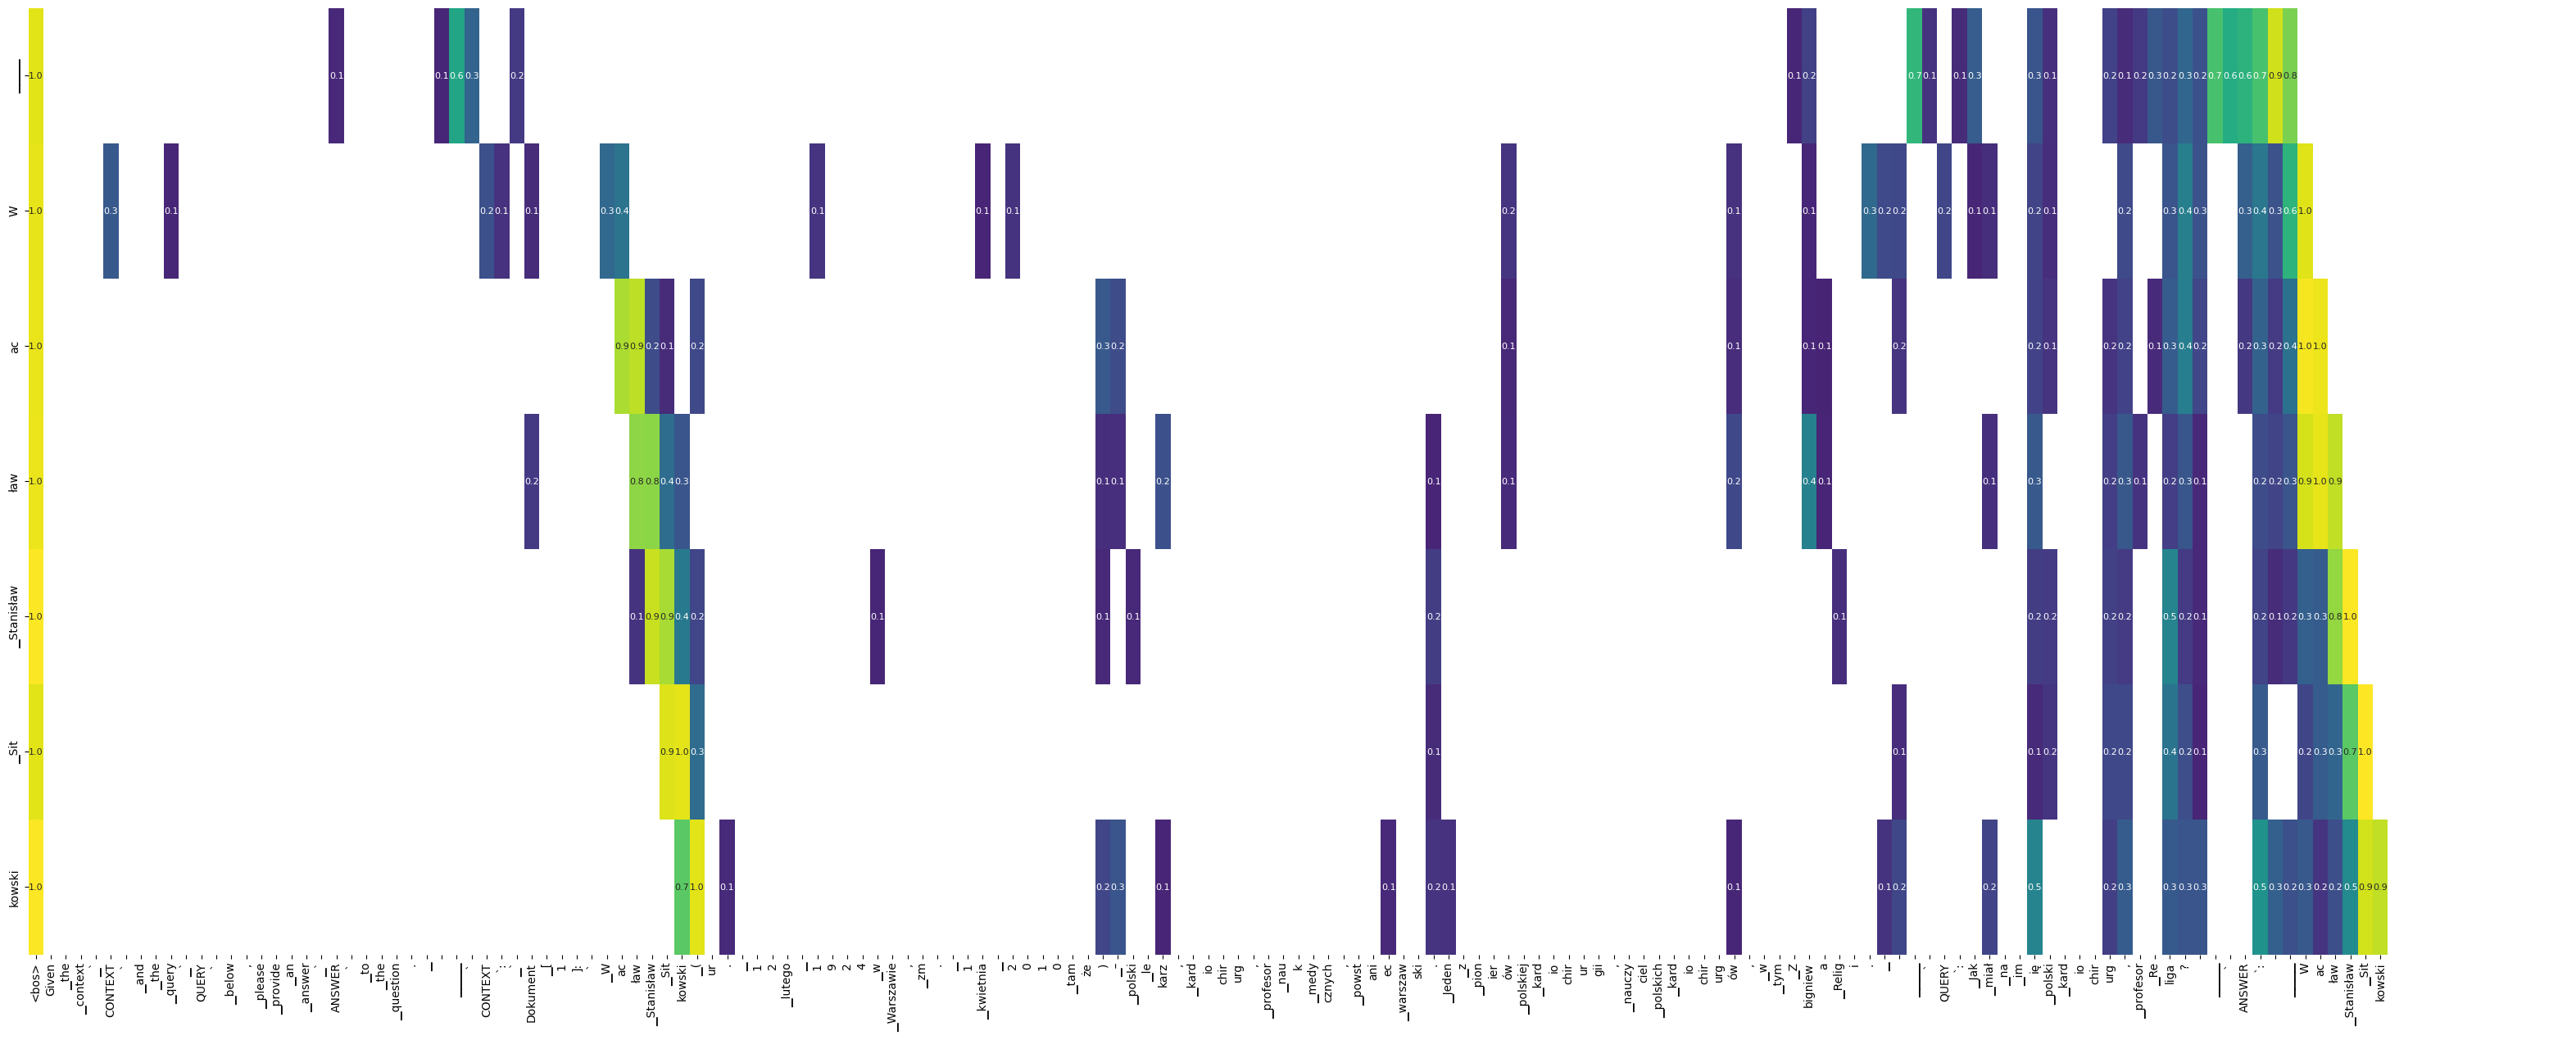

In [209]:
fig, ax = plt.subplots(figsize=(40, 15))

sns.heatmap(
    final_att_matrix[1:8, :],
    cmap="viridis",
    annot=True,
    fmt=".1f",
    annot_kws={"size": 8},
    cbar=False,
    square=False,
    mask=final_att_matrix[1:8, :] <= 0.1,
    vmin=0,
    vmax=1,
    ax=ax,
    # xticklabels=[f'tok_{i}'],
    yticklabels=ticks[first_gen_token_idx: first_gen_token_idx + 7],
    xticklabels=ticks[:first_gen_token_idx + 7],
)

plt.show()

### In the plot above you can see attensions aggregated by `max()` function on all layers and all heads. I only show values above `0.1`. As you can see the hallucination here has not been the result of putting to little attension to `context` tokens, but putting attension to `inpropriate tokens in context` - so here simply modyfing context tokens attenion would not work. The answer was at the end of context which has been `noised` with info about another person. Also it shows why authors of `Lookback Lens` dit not simply take max `lookback ratio` and put them into classifier. And also look how this answer is completly ridiculous - the query is about the **first name**, but in the response we are given **first name** and **last name** ! Aside from the fact that it's a different person.

## Conclusions

### Good direction is to check how does attenions and hidden states differentiate between proper and halucinated examples.